## 1. Imports & Configuration

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = (
    torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cuda" if torch.cuda.is_available() else "cpu")
)
print("Using device:", device)

Using device: mps


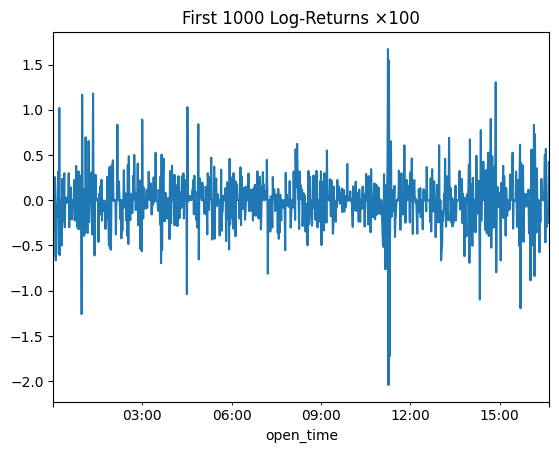

In [2]:
# 2. Load & Preprocess BNB/USDT Returns
df = pd.read_csv(
    '/Users/mchildress/Active Code/ts_basics/data/bnbusdt_1m.csv',
    parse_dates=['open_time'], index_col='open_time'
)
df['log_ret'] = np.log(df['close']).diff()
rets = df['log_ret'].dropna() * 100.0  # scale up
rets.iloc[:1000].plot(title='First 1000 Log‑Returns ×100')
plt.show()

In [3]:
# 3.5. Import base LSTM class via importlib
import importlib.util
import os
import sys

lstm_path = os.path.expanduser(
    '/Users/mchildress/Active Code/ts_basics/Modeling/src/models/4_lstm.py'
)
spec = importlib.util.spec_from_file_location("models._4_lstm", lstm_path)
lstm_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(lstm_module)
sys.modules["sine_lstm"] = lstm_module
SineLSTM = lstm_module.SineLSTM


In [4]:
# 3. Create Sliding Windows for Sequences
SEQ_LEN = 60
FUTURE = 0
data = rets.values.astype(np.float32)
X, Y = [], []
for i in range(len(data) - SEQ_LEN):
    X.append(data[i:i+SEQ_LEN])
    Y.append(data[i+SEQ_LEN])
X = np.stack(X)
Y = np.stack(Y)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train).unsqueeze(1))
test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test).unsqueeze(1))
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

In [5]:
# 4. Adapt LSTM for Return Prediction
class ReturnLSTM(SineLSTM):
    def forward(self, x, future=0):
        outputs = super().forward(x, future=0)
        return outputs[:, -1].unsqueeze(1)

In [6]:
# 5. Instantiate Model, Loss & Optimizer
model = ReturnLSTM(input_size=1, hidden_size=64).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# 6. Training Loop
from tqdm.auto import tqdm

# Re-create loaders with pin_memory and multiple workers
train_loader = DataLoader(train_ds, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

EPOCHS = 20
for epoch in range(1, EPOCHS+1):
    model.train()
    train_losses = []
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch} / {EPOCHS}", leave=False):
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    test_losses = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            test_losses.append(criterion(model(xb), yb).item())

    print(f"Epoch {epoch:02d}  Train {np.mean(train_losses):.4f}  Test {np.mean(test_losses):.4f}")

/Users/mchildress/.pyenv/versions/3.11.12/envs/dream/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 1 / 20:   0%|          | 0/11486 [00:00<?, ?it/s]/Users/mchildress/.pyenv/versions/3.11.12/envs/dream/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1 / 20:  11%|█         | 1228/11486 [03:21<28:09,  6.07it/s]libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception

: 

In [9]:
# 7. Plot Actual vs. Predicted Returns
model.eval()
xb, yb = next(iter(test_loader))

# Move both inputs and targets to the right device
xb, yb = xb.to(device), yb.to(device)

with torch.no_grad():
    pred = model(xb).squeeze().cpu().numpy()   # bring predictions back to CPU
    true = yb.squeeze().cpu().numpy()         # bring ground‑truth back to CPU

plt.figure(figsize=(10,4))
plt.plot(true, label='True')
plt.plot(pred, alpha=0.7, label='Pred')
plt.legend()
plt.title('One‑Step Return Prediction on Test Batch')
plt.show()

RuntimeError: Tensor for argument input is on cpu but expected on mps

1. The data itself is extremely noisy
	•	Those first‑1000 log‑returns swing rapidly around zero, with occasional big spikes up or down. The randomness make it hard to predict one step ahead
2.	This is basically returning “no change”
	•	If you look at the test‑batch plot, the “Pred” line is a nearly flat line sitting just above zero. Whenever the model isn’t sure what to predict, it falls back to predicting essentially zero return.
3.	Training and test losses barely budge
	•	Over 20 epochs the training loss only creeps down from ~0.0251 to ~0.0245, and the test loss stays stuck around ~0.0071. That tells us two things:
	•	The model isn’t over‑fitting (since test loss doesn’t explode), but
	•	It also isn’t learning meaningful patterns beyond the trivial “predict zero” baseline.
4.	Bottom‑line: this simple setup isn’t capturing
    any signal
	•	For ultra‑noisy, one‑minute crypto returns, a bare‑bones two‑layer LSTM with no extra features or regularization is reverting to the “zero‑return” guess.
	•	The mean‑squared error is roughly what you’d get if you always predicted 0, and it never improves on that.

## 9. Feature Engineering & Model Enhancements
Now that we have our baseline results, let’s add some time‑series features and build a more complex model (longer sequences, dropout, deeper LSTM, and convolutional preprocessing) to see if we can capture more signal.

In [ ]:
# 9.4. Import EnhancedLSTM and instantiate, train & evaluate enhanced model
import importlib.util
import os

enhanced_path = os.path.expanduser('/Users/mchildress/Active Code/ts_basics/Modeling/src/models/4_lstm_enhanced.py')
spec2 = importlib.util.spec_from_file_location("enhanced_lstm", enhanced_path)
enhanced_module = importlib.util.module_from_spec(spec2)
spec2.loader.exec_module(enhanced_module)
EnhancedLSTM = enhanced_module.EnhancedLSTM

# Define feat_cols. Adjust the list to include your desired features.
feat_cols = ['log_ret']

# Create sliding windows for Enhanced LSTM using feat_cols data
data2 = df[feat_cols].dropna().values.astype(np.float32)
X2, Y2 = [], []
for i in range(len(data2) - SEQ_LEN):
    X2.append(data2[i:i+SEQ_LEN])
    Y2.append(data2[i+SEQ_LEN, 0])
X2 = np.stack(X2)
Y2 = np.stack(Y2)
split2 = int(len(X2) * 0.8)
X2_train, X2_test = X2[:split2], X2[split2:]
Y2_train, Y2_test = Y2[:split2], Y2[split2:]
train_ds2 = TensorDataset(torch.from_numpy(X2_train), torch.from_numpy(Y2_train).unsqueeze(1))
test_ds2 = TensorDataset(torch.from_numpy(X2_test), torch.from_numpy(Y2_test).unsqueeze(1))
train_loader2 = DataLoader(train_ds2, batch_size=64, shuffle=True)
test_loader2 = DataLoader(test_ds2, batch_size=64)

model2 = EnhancedLSTM(input_size=len(feat_cols), hidden_size=64).to(device)
opt2   = optim.Adam(model2.parameters(), lr=1e-3)
crit2  = nn.MSELoss()

EPOCHS2 = 20
for epoch in range(1, EPOCHS2+1):
    model2.train()
    train_losses2 = []
    for xb, yb in train_loader2:
        xb, yb = xb.to(device), yb.to(device)
        opt2.zero_grad()
        pred2 = model2(xb)
        loss2 = crit2(pred2, yb)
        loss2.backward()
        opt2.step()
        train_losses2.append(loss2.item())
    model2.eval()
    test_losses2 = []
    with torch.no_grad():
        for xb, yb in test_loader2:
            xb, yb = xb.to(device), yb.to(device)
            test_losses2.append(crit2(model2(xb), yb).item())
    print(f"Epoch {epoch:02d}  Train2 {np.mean(train_losses2):.4f}  Test2 {np.mean(test_losses2):.4f}")

# 9.5. Plot predictions of the enhanced model on a batch
xb, yb = next(iter(test_loader2))
xb, yb = xb.to(device), yb.to(device)
with torch.no_grad():
    pred_batch = model2(xb).squeeze().cpu().numpy()
    true_batch = yb.squeeze().cpu().numpy()

plt.figure(figsize=(10,4))
plt.plot(true_batch, label='True')
plt.plot(pred_batch, label='Pred2')
plt.legend()
plt.title('Enhanced Model One‑Step Return Prediction')
plt.show()

Epoch 01  Train2 0.0000  Test2 0.0000


KeyboardInterrupt: 